<a href="https://www.kaggle.com/code/lferrors/bank-customer-churn-exploration?scriptVersionId=209539334" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bank-customer-churn/Customer-Churn-Records.csv


In [2]:
tmp_churn_df = pd.read_csv('/kaggle/input/bank-customer-churn/Customer-Churn-Records.csv')

tmp_churn_df.columns = [c.lower() for c in tmp_churn_df.columns]
#убираем первую колонку с номером строки
tmp_churn_df = tmp_churn_df.iloc[:,1:]
tmp_churn_df = tmp_churn_df.set_index('customerid')
#убираем колонку с фамилиями. при необходимости ее можно получить по 'customerid' из изначальной таблицы
tmp_churn_df = tmp_churn_df.drop('surname',axis=1)
tmp_churn_df = tmp_churn_df.sort_values(by=['creditscore'])

#некоторые типы данных избыточны. уменьшим их
tmp_churn_df[['creditscore', 'age', 'tenure', 'numofproducts', 'satisfaction score', 'point earned']] = (
    tmp_churn_df[['creditscore', 'age', 'tenure', 'numofproducts', 'satisfaction score', 'point earned']]
    .astype('int16')
)

tmp_churn_df[['hascrcard', 'isactivemember', 'exited', 'complain']] = (
    tmp_churn_df[['hascrcard', 'isactivemember', 'exited', 'complain']]
    .astype(bool)
)

tmp_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 15765173 to 15641604
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   creditscore         10000 non-null  int16  
 1   geography           10000 non-null  object 
 2   gender              10000 non-null  object 
 3   age                 10000 non-null  int16  
 4   tenure              10000 non-null  int16  
 5   balance             10000 non-null  float64
 6   numofproducts       10000 non-null  int16  
 7   hascrcard           10000 non-null  bool   
 8   isactivemember      10000 non-null  bool   
 9   estimatedsalary     10000 non-null  float64
 10  exited              10000 non-null  bool   
 11  complain            10000 non-null  bool   
 12  satisfaction score  10000 non-null  int16  
 13  card type           10000 non-null  object 
 14  point earned        10000 non-null  int16  
dtypes: bool(4), float64(2), int16(6), object(3)
memo

<Axes: >

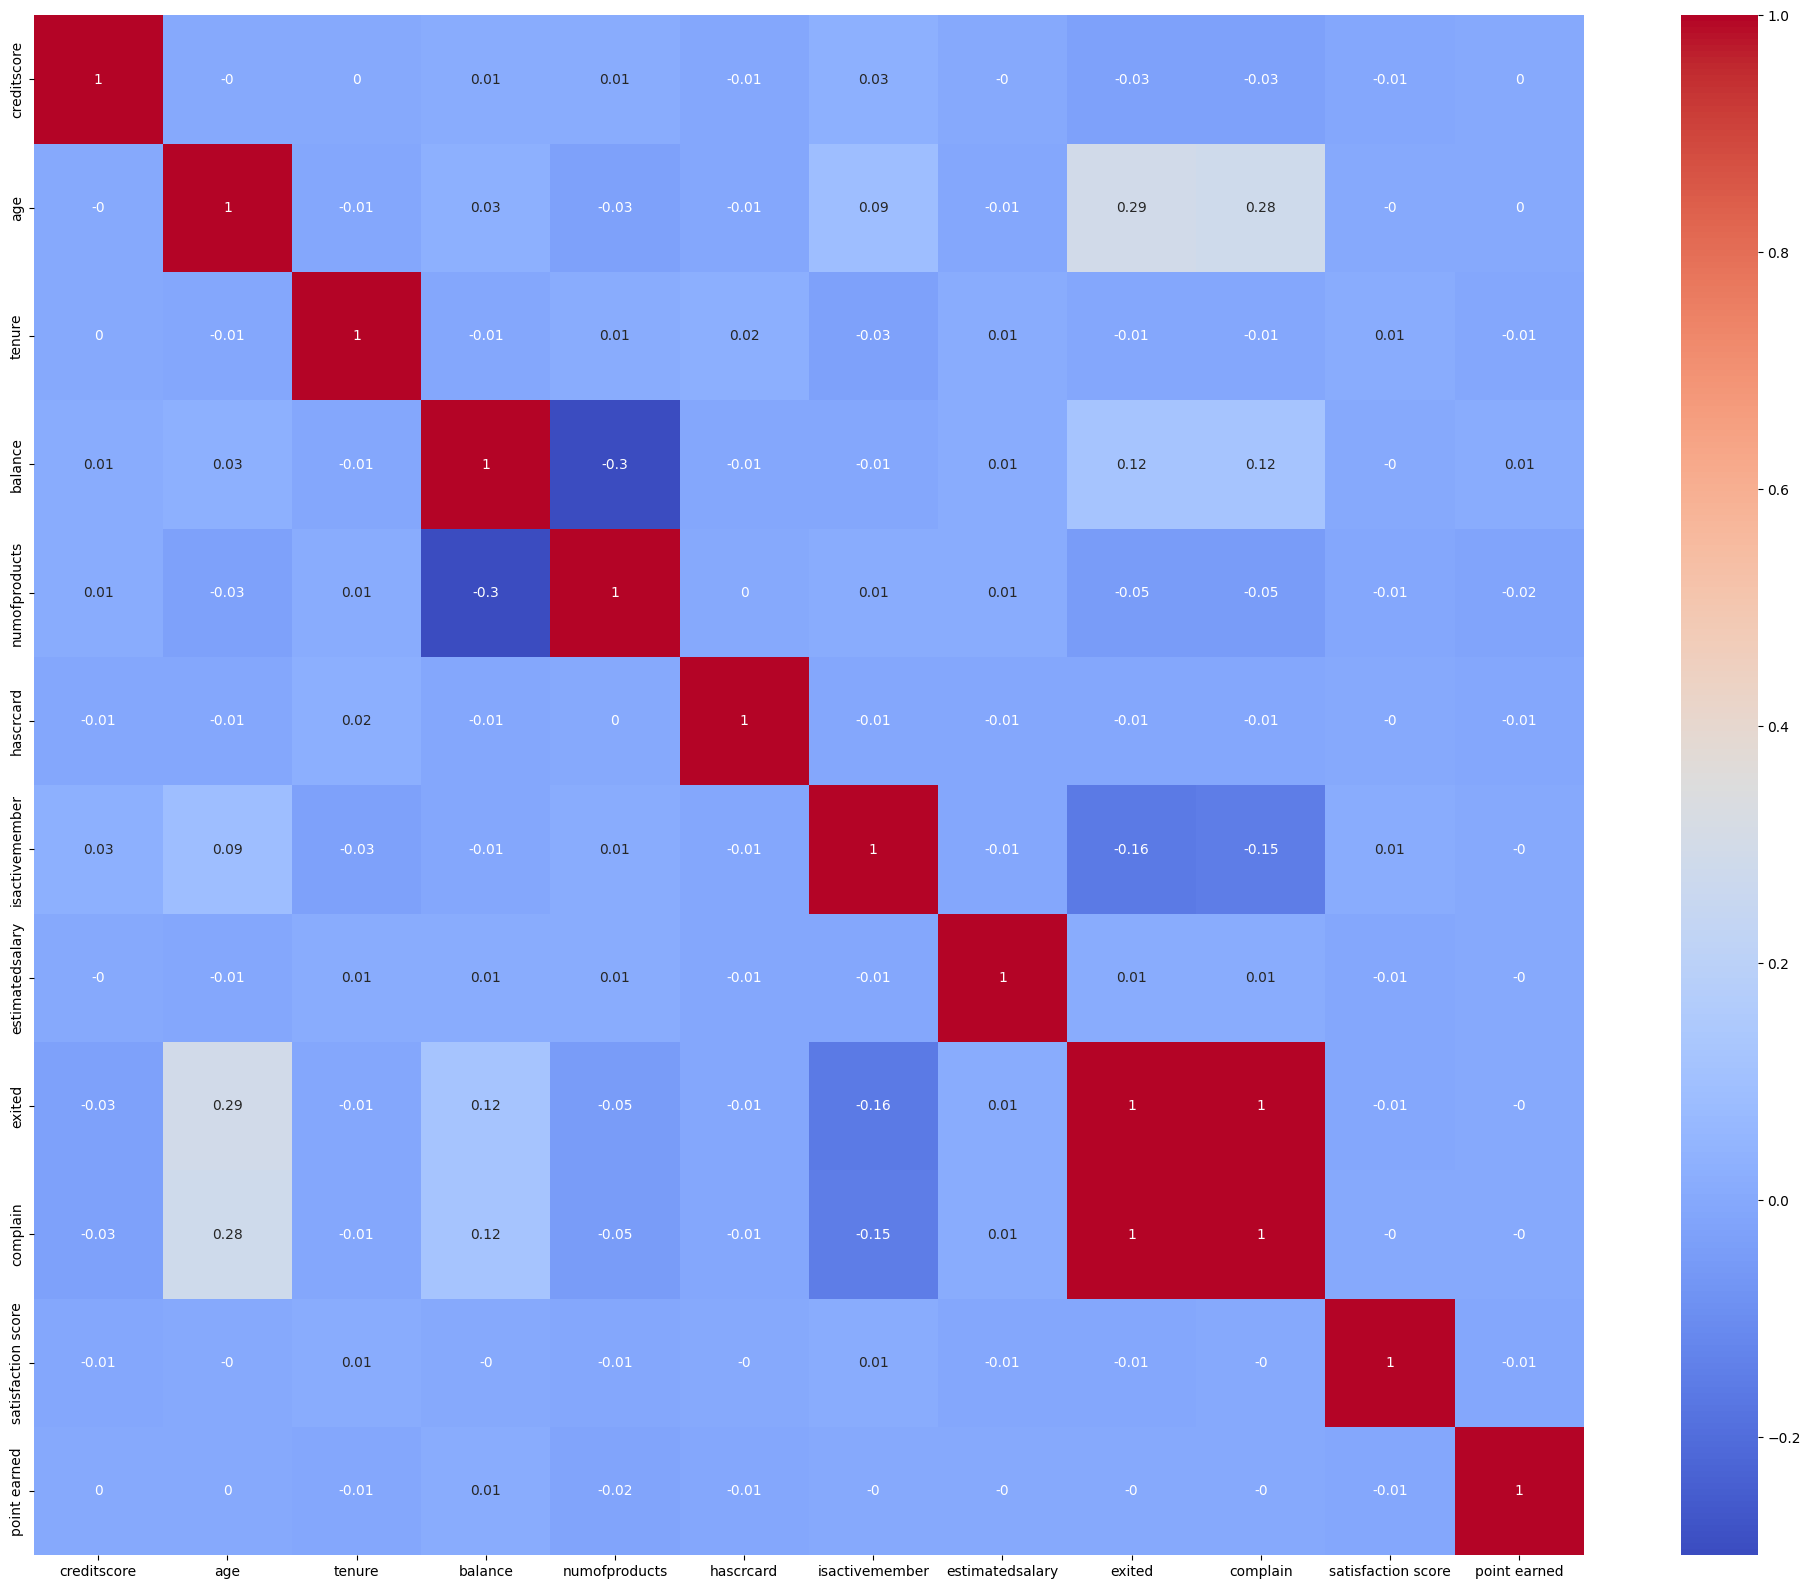

In [3]:
corr = tmp_churn_df.corr(numeric_only=True).round(2)

fig = plt.figure(figsize = (25,20))

sns.heatmap(corr, annot = True, cmap = 'coolwarm')

Ключевой параметр 'exited' полностью совпадает с побочным 'complain' по корреляциям, поэтому от 'complain' можно избавиться

In [4]:
tmp_churn_df = tmp_churn_df.drop('complain',axis=1)

Наибольшая корреляция текучки клиентов связана с их возрастом. Рассмотрим подробнее статистику по возрастам  

Text(0, 0.5, 'Percent of churn')

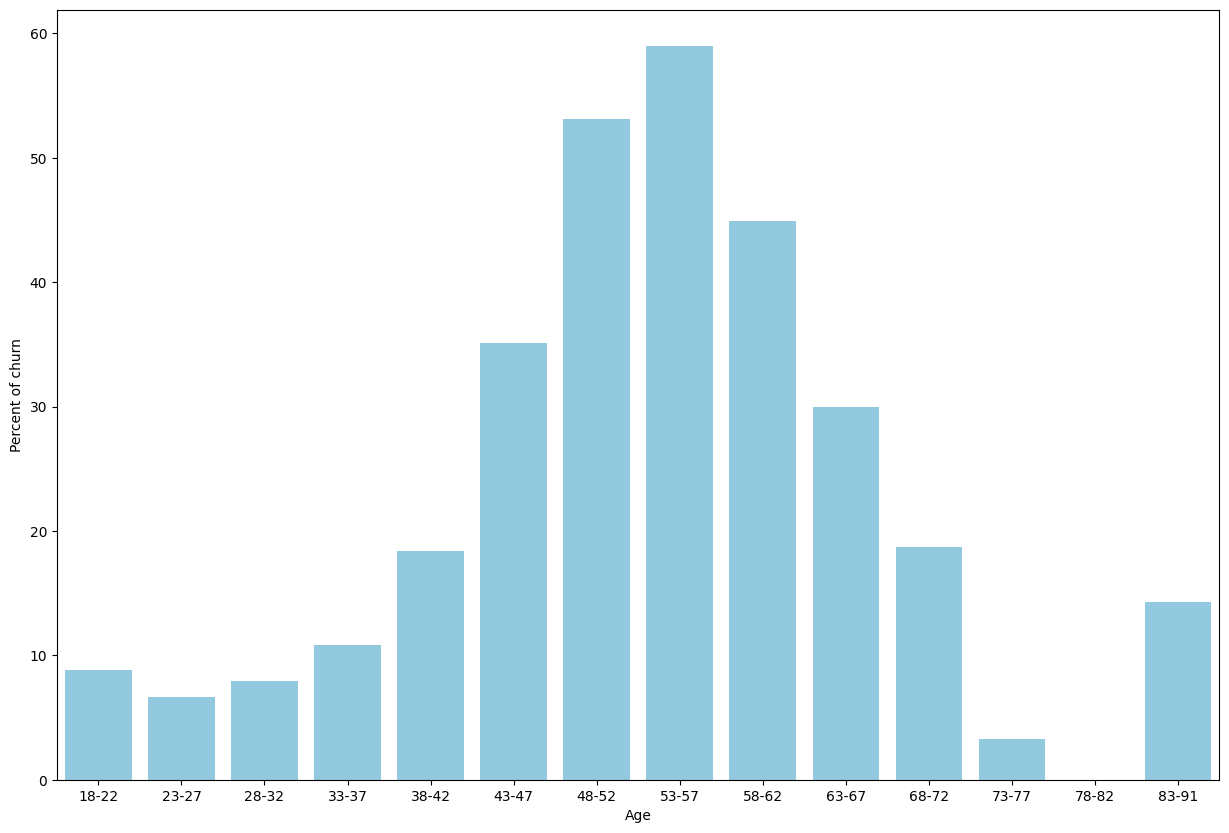

In [5]:
age_exited_df = tmp_churn_df[['age','exited']].groupby(['age']).agg({'exited': ['count','sum']})['exited']

#делим возрастные группы по 5 лет(некотрые возраста отсутствуют, поэтому промежутки бывают больше)
dx=5

tmp_values = []

tmp_index = age_exited_df['sum'].keys()[::dx].append(age_exited_df['sum'].keys()[-1:-2:-1])

#индексы для новых групп
index_ = [f'{tmp_index[i]}-{tmp_index[i+1]-1}' for i in range(len(tmp_index) - 1)]

#заполняем массив процентами оттока по возрасту
for i in range(int(age_exited_df.shape[0]/dx)): 
    s = round(age_exited_df['sum'][0 + dx*i:dx + dx*i]
              .values.sum() / age_exited_df['count'][0 + dx*i:dx + dx*i]
              .values.sum() * 100,2)
    tmp_values.append(s)

age_exited_percent_df = pd.DataFrame(tmp_values, index=index_)


fig = plt.figure(figsize=(15,10))

chart = sns.barplot(age_exited_percent_df,x=age_exited_percent_df[0].keys(), y=age_exited_percent_df[0].values, color='SkyBlue')

chart.set_xlabel('Age')

chart.set_ylabel('Percent of churn')

Заметим, что основной(и довольно большой) отток клиентов проходит в возрасте ~43-67 лет. Сфокусируемся на них

In [6]:
focuse_age_df = tmp_churn_df[(tmp_churn_df['age']>= 43) & (tmp_churn_df['age']<=67)]

active_focuse_age_df = focuse_age_df[ focuse_age_df['isactivemember'] == True ].drop('isactivemember', axis=1)

inactive_focuse_age_df = focuse_age_df[ focuse_age_df['isactivemember'] == False ].drop('isactivemember', axis=1)

focuse_age_df

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,satisfaction score,card type,point earned
customerid,,,,,,,,,,,,,,
15765173,350,France,Female,60,3,0.00,1,False,False,113796.15,True,1,SILVER,958
15803202,350,France,Male,51,10,0.00,1,True,True,125823.79,True,4,GOLD,383
15685372,350,Spain,Male,54,1,152677.48,1,True,True,191973.49,True,3,SILVER,643
15679249,351,Germany,Female,57,4,163146.46,1,True,False,169621.69,True,4,SILVER,453
15692416,358,Spain,Female,52,8,143542.36,3,True,False,141959.11,True,4,SILVER,976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15707473,850,Germany,Female,48,6,111962.99,1,True,False,111755.80,False,5,GOLD,446
15811958,850,Germany,Male,44,2,112755.34,2,False,False,158171.36,False,5,SILVER,842
15662100,850,Germany,Female,44,5,128605.32,1,False,True,171096.20,False,2,PLATINUM,952


<Axes: >

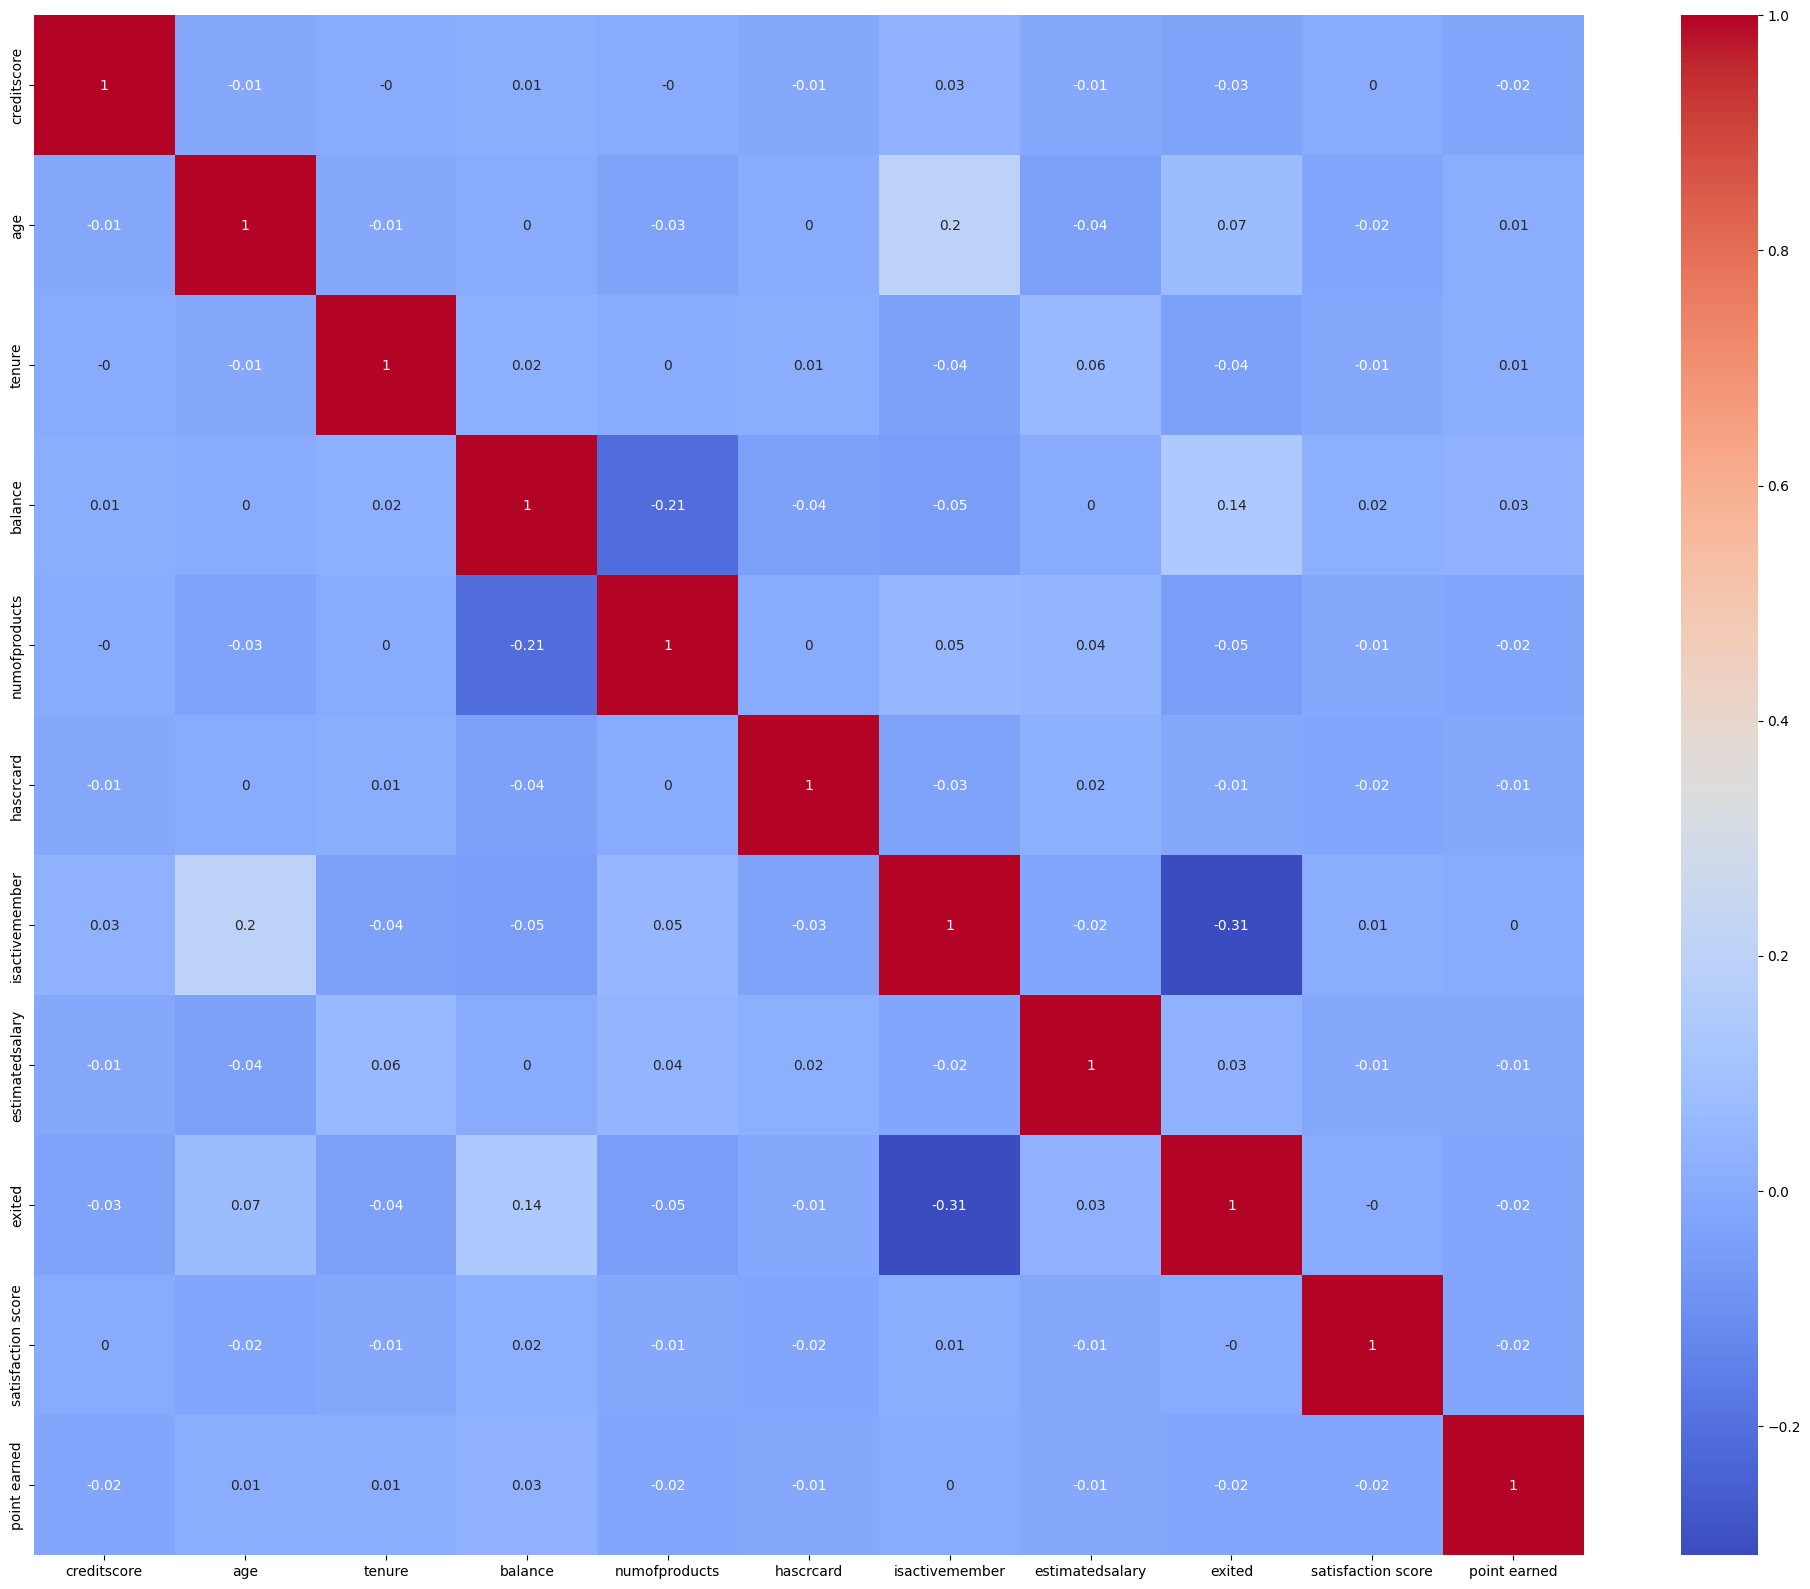

In [7]:
corr = focuse_age_df.corr(numeric_only=True).round(2)

fig = plt.figure(figsize = (25,20))

sns.heatmap(corr, annot = True, cmap = 'coolwarm')

Активные взрослые пользователи банка менее подвержены оттоку. Посмотрим на зависимость оттока от страны проживания  

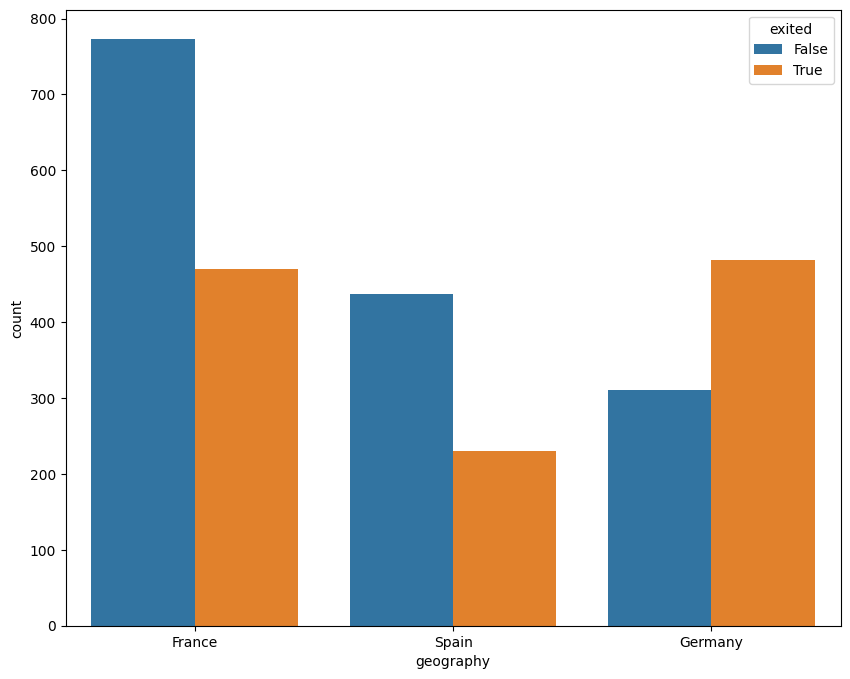

In [8]:
plt.figure(figsize=(10, 8))

sns.countplot(x='geography', hue='exited', data=focuse_age_df)

plt.show()

Находим интересную ситуация с ВЗРОСЛЫМИ клиентами из ГЕРМАНИИ! При этом график по всем пользователям(рисунок ниже), вне зависимости от их возраста, выглядит, на первый взгляд, прилично

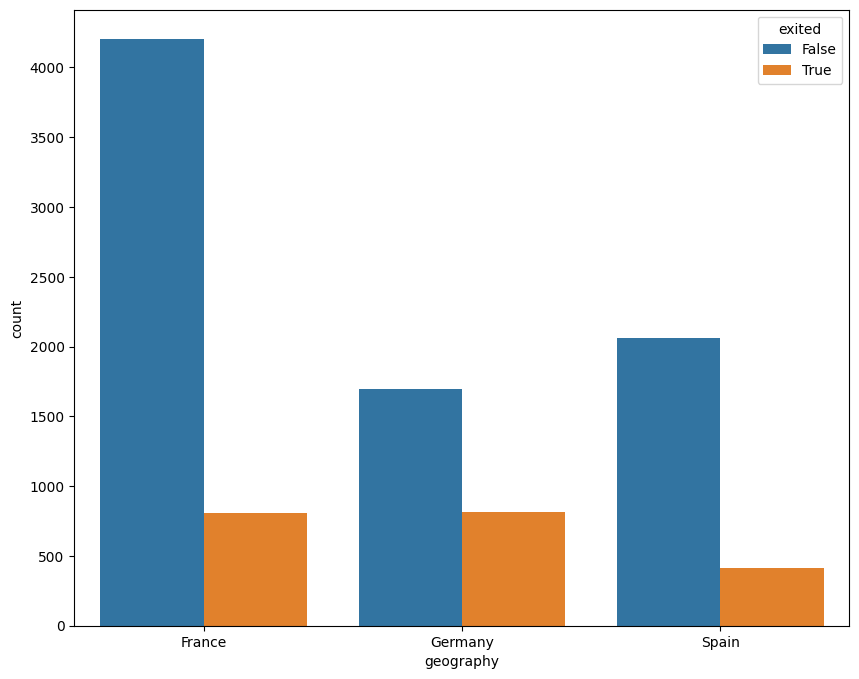

In [9]:
plt.figure(figsize=(10, 8))

sns.countplot(x='geography', hue='exited', data=tmp_churn_df)

plt.show()

Тогда углубимся в изучение пользователей банка в Германии

In [10]:
germany_churn_df = tmp_churn_df[tmp_churn_df['geography'] == 'Germany'].drop(['geography'], axis=1)

aged_germany_churn_df = focuse_age_df[focuse_age_df['geography'] == 'Germany'].drop(['geography'], axis=1)



aged_germany_churn_df 

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,satisfaction score,card type,point earned
customerid,,,,,,,,,,,,,
15679249,351,Female,57,4,163146.46,1,True,False,169621.69,True,4,SILVER,453
15651052,399,Male,46,2,127655.22,1,True,False,139994.68,True,5,PLATINUM,475
15753332,401,Male,48,8,128140.17,1,True,False,175753.55,True,2,GOLD,382
15718893,404,Female,54,4,125456.07,1,True,False,83715.66,True,3,PLATINUM,353
15572762,410,Female,50,2,102278.79,2,True,False,89822.48,False,5,PLATINUM,749
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15602010,850,Female,45,5,103909.86,1,True,False,60083.11,True,5,DIAMOND,312
15707473,850,Female,48,6,111962.99,1,True,False,111755.80,False,5,GOLD,446
15811958,850,Male,44,2,112755.34,2,False,False,158171.36,False,5,SILVER,842


In [11]:
aged_germany_avg_on_exit = (aged_germany_churn_df[['exited','creditscore','tenure','balance','numofproducts','estimatedsalary','point earned']]

                            .groupby(['exited']).agg(['mean'])

)

aged_germany_avg_on_exit

,creditscore,tenure,balance,numofproducts,estimatedsalary,point earned
,mean,mean,mean,mean,mean,mean
exited,,,,,,
False,647.858065,5.077419,122002.733419,1.561290,103547.472935,611.135484
True,647.091286,4.995851,120584.207739,1.429461,99150.467199,604.790456


Средние значения по измеримым величинам мало отличаются

In [12]:
aged_germany_avg_on_cardtype = (aged_germany_churn_df[['card type','exited','creditscore','tenure','balance','numofproducts','estimatedsalary','point earned']]

                            .groupby(['card type','exited']).agg(['mean'])

)

aged_germany_avg_on_cardtype

creditscore    tenure        balance numofproducts  \
                        mean      mean           mean          mean   
card type exited                                                      
DIAMOND   False   649.391892  5.108108  119277.786351      1.486486   
          True    641.547445  5.087591  120271.209562      1.430657   
GOLD      False   643.584416  5.519481  125038.138182      1.506494   
          True    654.528000  5.176000  119363.352160      1.408000   
PLATINUM  False   642.296296  4.555556  122415.374074      1.604938   
          True    648.426230  4.852459  121159.520820      1.500000   
SILVER    False   656.397436  5.153846  121162.938846      1.641026   
          True    643.693878  4.816327  121862.774082      1.367347   

                 estimatedsalary point earned  
                            mean         mean  
card type exited                               
DIAMOND   False    100711.569730   623.040541  
          True      96876.601971   612.430657  
GOLD      False    102666.641169   591.584416  
          True     103259.375440   608.000000  
PLATINUM  False    109118.170370   595.765432  
          True      95756.025738   624.704918  
SILVER    False    101322.529231   635.102564  
          True     101314.016837   565.224490

Ситуация с разбивкой на тип карты. Средние значения выглядят хорошо

In [13]:
aged_germany_avg_on_gender = (aged_germany_churn_df[['gender','exited','creditscore','tenure','balance','numofproducts','estimatedsalary','point earned']]

                            .groupby(['gender','exited']).agg(['mean'])

)

aged_germany_avg_on_gender

creditscore    tenure        balance numofproducts  \
                     mean      mean           mean          mean   
gender exited                                                      
Female False   648.924138  4.731034  121100.624069      1.572414   
       True    648.714829  4.969582  120539.974563      1.422053   
Male   False   646.921212  5.381818  122795.496182      1.551515   
       True    645.141553  5.027397  120637.327945      1.438356   

              estimatedsalary point earned  
                         mean         mean  
gender exited                               
Female False     99978.696345   589.517241  
       True     100415.583118   611.977186  
Male   False    106683.670545   630.133333  
       True      97631.172740   596.159817

Аналогично разбивка по полу. Посмотрим на распределения средних значений

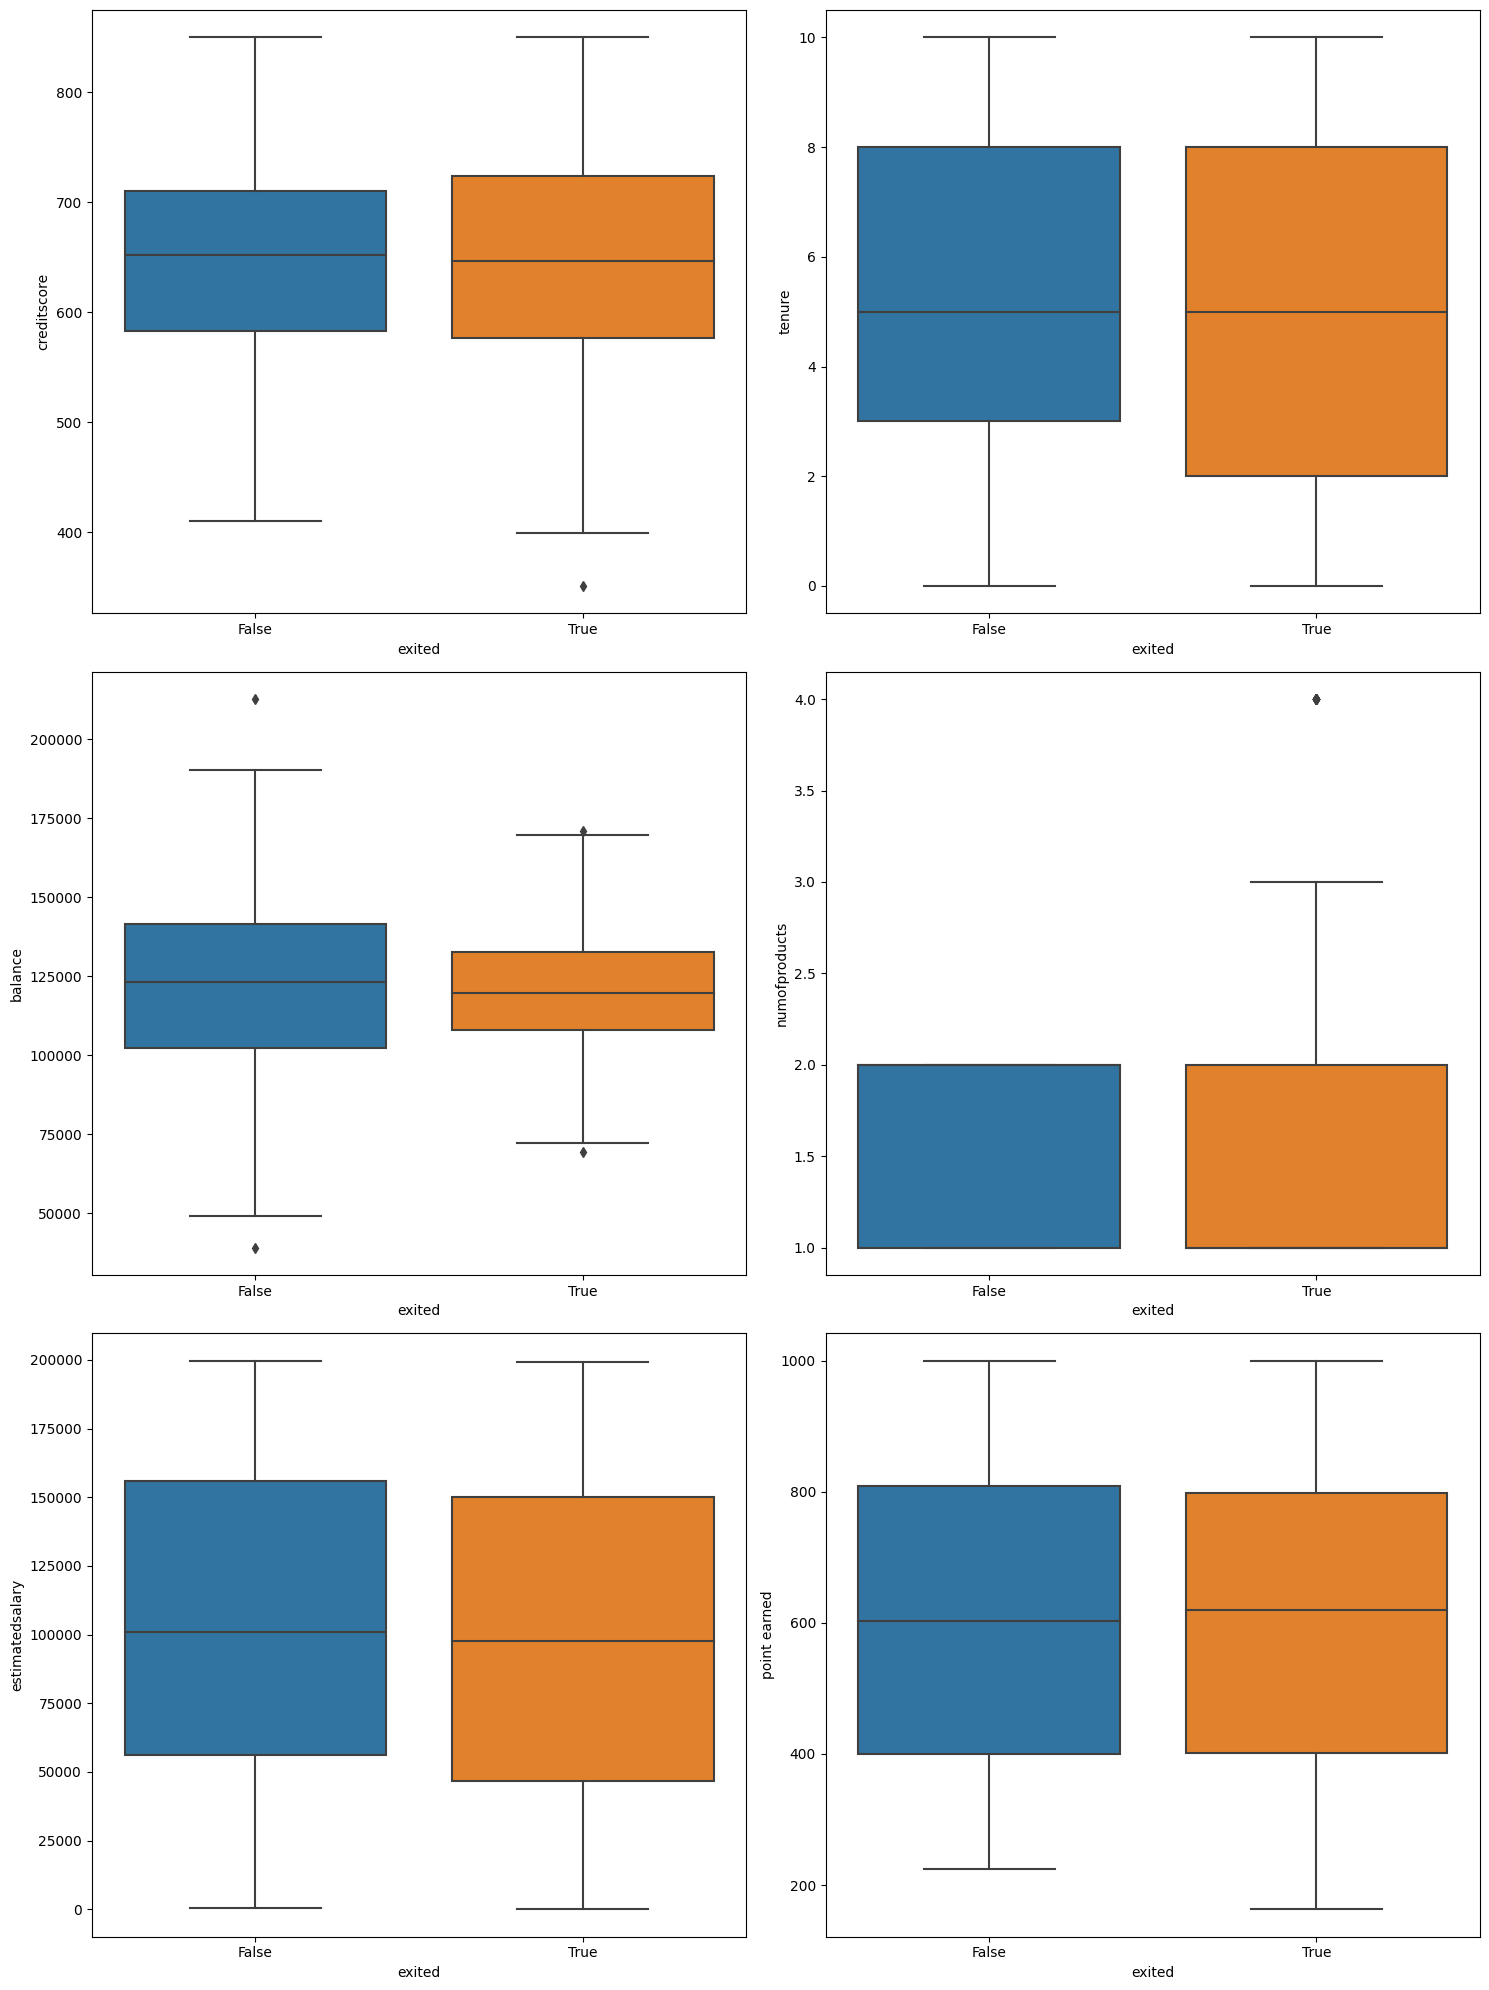

In [14]:
f, axs = plt.subplots(3, 2, figsize=(15,20))

sns.boxplot(data=aged_germany_churn_df,x='exited',y='creditscore', ax=axs[0,0])

sns.boxplot(data=aged_germany_churn_df,x='exited',y='tenure',ax = axs[0,1])

sns.boxplot(data=aged_germany_churn_df,x='exited',y='balance', ax=axs[1,0])

sns.boxplot(data=aged_germany_churn_df,x='exited',y='numofproducts',ax = axs[1,1])

sns.boxplot(data=aged_germany_churn_df,x='exited',y='estimatedsalary', ax=axs[2,0])

sns.boxplot(data=aged_germany_churn_df,x='exited',y='point earned',ax = axs[2,1])

f.tight_layout() 

Text(0.5, 0, 'Percent in Germany')

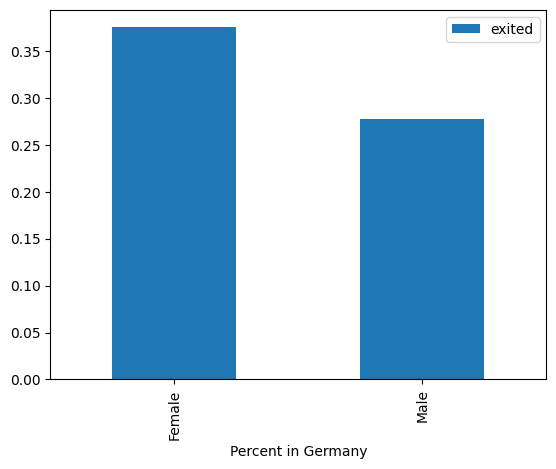

In [15]:
germany_gender_churn = germany_churn_df[['gender','exited']].groupby(['gender']).agg(lambda x: x.agg('sum')/x.agg('count'))
all_gender_churn = tmp_churn_df[['gender','exited']].groupby(['gender']).agg(lambda x: x.agg('sum')/x.agg('count'))

germany_gender_churn.plot(kind='bar').set_xlabel('Percent in Germany')

Text(0.5, 0, 'Percent in all countries')

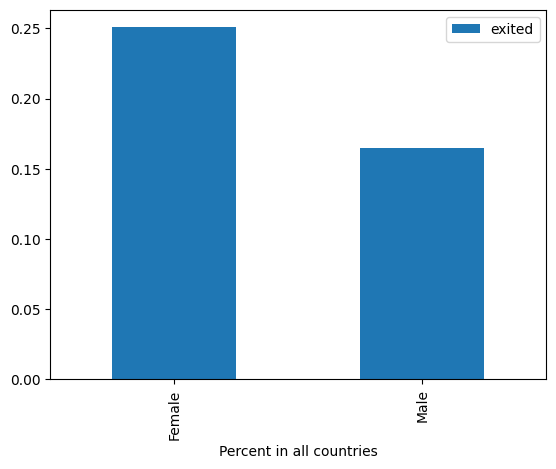

In [16]:
all_gender_churn.plot(kind='bar').set_xlabel('Percent in all countries')

Получаем, что интересующая нас группа людей это женщины из Германии в возрасте 43-67 лет. По текущим данным тяжело определить конкретные недовольства данной группы, нужно смотреть на внешние источники: обстановку в стране, появление высокой конкуренции в среде банков, возможные изменения в законах или политики самой компании. Необходимо смотреть на даты, когда клиенты стали покидать банк, но в текущей таблицы они не представлены. 

Дальнейший анализ по внешним источникам следует обсудить с командой и руководством. А так же попросить дата-инженера достать временные метк 

и.